In [1]:
import pandas as pd 
import glob
import cv2 as cv
import random
import os

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import f1_score, accuracy_score


from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
from tqdm.auto import tqdm
import timm
import math
from sklearn.model_selection import train_test_split
import pytorch_model_summary
from pkg_resources import packaging
import clip

c:\Users\EHmin\anaconda3\envs\EHmin\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Make DataFrame

## columns: review_img_path, product_img_path, label
---

In [2]:
all_product_img_list = glob.glob('./masked_data/product_img/*')
all_product_img_list = sorted(all_product_img_list)
print(all_product_img_list)

['./masked_data/product_img\\0.jpg', './masked_data/product_img\\1.jpg', './masked_data/product_img\\10.jpg', './masked_data/product_img\\100.jpg', './masked_data/product_img\\12.jpg', './masked_data/product_img\\13.jpg', './masked_data/product_img\\14.jpg', './masked_data/product_img\\15.jpg', './masked_data/product_img\\20.jpg', './masked_data/product_img\\25.jpg', './masked_data/product_img\\28.jpg', './masked_data/product_img\\30.jpg', './masked_data/product_img\\33.jpg', './masked_data/product_img\\34.jpg', './masked_data/product_img\\35.jpg', './masked_data/product_img\\36.jpg', './masked_data/product_img\\37.jpg', './masked_data/product_img\\39.jpg', './masked_data/product_img\\4.jpg', './masked_data/product_img\\40.jpg', './masked_data/product_img\\41.jpg', './masked_data/product_img\\42.jpg', './masked_data/product_img\\43.jpg', './masked_data/product_img\\45.jpg', './masked_data/product_img\\46.jpg', './masked_data/product_img\\48.jpg', './masked_data/product_img\\49.jpg', '.

In [3]:
review_img_path = []
product_img_path = []
label = []
for product_img in all_product_img_list:
    glob_img_list = []
    str = product_img.split("\\")[1] # for window
    # str = product_img.split("/")[3] # for linux
    
    str = str.split(".")[0]
    glob_img_list = glob.glob('./masked_data/review_img/'+str +'_review_img/O/*.jpg')
    review_img_path = review_img_path + glob_img_list
    product_img_path = product_img_path + [product_img  for i in range(len(glob_img_list))]

In [4]:
print(len(product_img_path))
print(len(review_img_path))


18749
18749


In [5]:
for i in range(len(review_img_path)):
    random_number = random.randint(0, 1)
    if random_number == 0:
        label.append(0)
    else:
        review_num = review_img_path[i].split('\\')[1] # for Window 
        # review_num = review_img_path[i].split('/')[3] # for Linux
        
        review_num = review_num.split("_")[0]
        random_number = random.randint(0, len(all_product_img_list) - 1)
        while review_num == random_number:
            random_number = random.randint(0, len(all_product_img_list) - 1)
        product_img_path[i] = all_product_img_list[random_number]
        label.append(1)

In [6]:
df = pd.DataFrame(columns=['review_img_path','product_img_path', 'label'])
df['review_img_path'] = review_img_path
df['product_img_path'] = product_img_path
df['label'] = label

df

,review_img_path,product_img_path,label
0,./masked_data/review_img/0_review_img/O\1.jpg,./masked_data/product_img\90.jpg,1
1,./masked_data/review_img/0_review_img/O\107.jpg,./masked_data/product_img\98.jpg,1
2,./masked_data/review_img/0_review_img/O\109.jpg,./masked_data/product_img\0.jpg,0
3,./masked_data/review_img/0_review_img/O\111.jpg,./masked_data/product_img\100.jpg,1
4,./masked_data/review_img/0_review_img/O\119.jpg,./masked_data/product_img\34.jpg,1
...,...,...,...
18744,./masked_data/review_img/98_review_img/O\93.jpg,./masked_data/product_img\46.jpg,1
18745,./masked_data/review_img/98_review_img/O\95.jpg,./masked_data/product_img\30.jpg,1
18746,./masked_data/review_img/98_review_img/O\96.jpg,./masked_data/product_img\98.jpg,0
18747,./masked_data/review_img/98_review_img/O\97.jpg,./masked_data/product_img\98.jpg,0


---

# Bring Clip

In [7]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [8]:
model, preprocess = clip.load("ViT-B/32")

# Pred distance by Resnet

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':1,
    'LEARNING_RATE':3e-3,
    # 'LEARNING_RATE':10,
    'BATCH_SIZE':1,
    'SEED':41
}

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = 'a'
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [12]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])


In [13]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,review_img_path,product_img_path,label,transform=None):
        self.review_img_path = review_img_path
        self.product_img_path = product_img_path
        self.label = label
        self.transform = transform
        
    def __getitem__(self,index):
        # review_img = cv.imread(self.review_img_path[index])
        # product_img = cv.imread(self.product_img_path[index])
        
        review_img = Image.open(self.review_img_path[index]).convert("RGB")
        product_img = Image.open(self.product_img_path[index]).convert("RGB")

        if self.transform is not None:
            review_img  = self.transform(review_img)
            product_img  = self.transform(product_img)
            
    
        return review_img, product_img, self.label[index]
    
    def __len__(self):
        return len(self.review_img_path)

In [14]:
train_transform = preprocess

In [15]:
train_dataset = SiameseNetworkDataset(train["review_img_path"].values, train["product_img_path"].values, train["label"].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = SiameseNetworkDataset(val["review_img_path"].values, val["product_img_path"].values, val["label"].values, train_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [16]:
avail_pretrained_models = timm.list_models('*resnet*', pretrained=True)
# avail_pretrained_models = timm.list_models(*resnet*, pretrained=True)

print(avail_pretrained_models)

['cspresnet50', 'eca_resnet33ts', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet269d', 'ecaresnetlight', 'ens_adv_inception_resnet_v2', 'gcresnet33ts', 'gcresnet50t', 'gluon_resnet18_v1b', 'gluon_resnet34_v1b', 'gluon_resnet50_v1b', 'gluon_resnet50_v1c', 'gluon_resnet50_v1d', 'gluon_resnet50_v1s', 'gluon_resnet101_v1b', 'gluon_resnet101_v1c', 'gluon_resnet101_v1d', 'gluon_resnet101_v1s', 'gluon_resnet152_v1b', 'gluon_resnet152_v1c', 'gluon_resnet152_v1d', 'gluon_resnet152_v1s', 'inception_resnet_v2', 'lambda_resnet26rpt_256', 'lambda_resnet26t', 'lambda_resnet50ts', 'legacy_seresnet18', 'legacy_seresnet34', 'legacy_seresnet50', 'legacy_seresnet101', 'legacy_seresnet152', 'nf_resnet50', 'resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_gn', 'resnet50d', 'resnet51q', 'resnet61q', 'resnet101', 'resnet1

In [17]:
def validation(model, criterion, val_loader, device):
    model.eval()
    distance_proper = []
    distance_unfit = []
    flag = True
    
    with torch.no_grad():
        for review_img, product_img, labels in tqdm(iter(val_loader)):
            # review_img = review_img.float().to(device)
            # product_img = product_img.float().to(device)
            
            review_img = torch.tensor(np.stack(review_img)).cuda()
            product_img = torch.tensor(np.stack(product_img)).cuda()
            
            review_image_features = model.encode_image(review_img).float()
            product_image_features = model.encode_image(product_img).float()
            
            review_image_features /= review_image_features.norm(dim=-1, keepdim=True)
            product_image_features /= product_image_features.norm(dim=-1, keepdim=True)
            
            
            if labels == 0:
                flag = True
            else:
                flag = False
            
            similarity = review_image_features.cpu().numpy() @ product_image_features.cpu().numpy().T
            
            
            if flag:
                distance_proper.append(similarity)
            else:
                distance_unfit.append(similarity)
                
        
    return distance_proper, distance_unfit

In [18]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model = model.to(device)
    criterion = nn.NLLLoss(reduction="sum").to(device)
    
    return validation(model, criterion, train_loader, device)

In [19]:
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [20]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

proper, unfit = train(model, optimizer, train_loader, val_loader, None, device)

100%|██████████| 13124/13124 [07:39<00:00, 28.53it/s]


In [21]:
proper

[array([[0.7761475]], dtype=float32),
 array([[0.8145632]], dtype=float32),
 array([[0.8384018]], dtype=float32),
 array([[0.77018154]], dtype=float32),
 array([[0.79043853]], dtype=float32),
 array([[0.6866751]], dtype=float32),
 array([[0.8935795]], dtype=float32),
 array([[0.81090266]], dtype=float32),
 array([[0.79566646]], dtype=float32),
 array([[0.82983214]], dtype=float32),
 array([[0.8579256]], dtype=float32),
 array([[0.7881494]], dtype=float32),
 array([[0.7019072]], dtype=float32),
 array([[0.77224076]], dtype=float32),
 array([[0.81029207]], dtype=float32),
 array([[0.88194]], dtype=float32),
 array([[0.8063573]], dtype=float32),
 array([[0.67505574]], dtype=float32),
 array([[0.69923425]], dtype=float32),
 array([[0.8840131]], dtype=float32),
 array([[0.832647]], dtype=float32),
 array([[0.717054]], dtype=float32),
 array([[0.69282496]], dtype=float32),
 array([[0.5609268]], dtype=float32),
 array([[0.5742363]], dtype=float32),
 array([[0.8593202]], dtype=float32),
 array

In [22]:
proper_0 = proper[0]

In [23]:
proper_0[0][0]

0.7761475

In [24]:
proper_int = []
for num in proper:
    proper_int.append(num[0][0])
print(proper_int)

[0.7761475, 0.8145632, 0.8384018, 0.77018154, 0.79043853, 0.6866751, 0.8935795, 0.81090266, 0.79566646, 0.82983214, 0.8579256, 0.7881494, 0.7019072, 0.77224076, 0.81029207, 0.88194, 0.8063573, 0.67505574, 0.69923425, 0.8840131, 0.832647, 0.717054, 0.69282496, 0.5609268, 0.5742363, 0.8593202, 0.8341794, 0.76564455, 0.9321411, 0.71956056, 0.87379193, 0.863773, 0.69639593, 0.6806264, 0.7696672, 0.88966286, 0.6961413, 0.8570421, 0.83583736, 0.68869, 0.8728764, 0.7214394, 0.8304386, 0.81640255, 0.87371814, 0.68450296, 0.8251543, 0.868852, 0.75993854, 0.8248795, 0.7536278, 0.88886917, 0.88605094, 0.732733, 0.629203, 0.8338798, 0.87751114, 0.8166252, 0.68902427, 0.9035183, 0.6858929, 0.75987476, 0.87573624, 0.85173345, 0.7219121, 0.7264563, 0.75773466, 0.88853747, 0.88144994, 0.74831104, 0.65192693, 0.8113357, 0.6671283, 0.7874574, 0.92418504, 0.853701, 0.69854015, 0.85128057, 0.8221758, 0.68869, 0.6167665, 0.86344975, 0.81429553, 0.87062174, 0.8922919, 0.9113702, 0.75778383, 0.7490222, 0.913

In [25]:
unfit_int = []
for num in unfit:
    unfit_int.append(num[0][0])
print(unfit_int)

[0.7934566, 0.7431612, 0.8776314, 0.72121024, 0.78916943, 0.8738395, 0.839777, 0.77613574, 0.6704772, 0.68941087, 0.73215365, 0.678549, 0.72034186, 0.71342963, 0.810554, 0.82898676, 0.65249175, 0.545912, 0.81563896, 0.7005138, 0.74950105, 0.7286458, 0.7526711, 0.7488665, 0.87640303, 0.88071454, 0.8156564, 0.8264442, 0.8195661, 0.65886784, 0.8234113, 0.7981927, 0.83145744, 0.7339665, 0.65576047, 0.825516, 0.7224922, 0.7338173, 0.87916875, 0.79852337, 0.7999828, 0.6844349, 0.77695656, 0.709861, 0.8580345, 0.5668765, 0.7965299, 0.6956133, 0.6916915, 0.6935625, 0.73844266, 0.8648023, 0.58263385, 0.8293909, 0.7141793, 0.6998026, 0.7748, 0.8338761, 0.820408, 0.78245306, 0.65503347, 0.67028654, 0.77059495, 0.8320684, 0.7417045, 0.6304387, 0.81972516, 0.8991016, 0.7419971, 0.66024005, 0.84556127, 0.8676845, 0.8491377, 0.71422714, 0.665359, 0.6382677, 0.8018411, 0.84940267, 0.7927917, 0.8445911, 0.7332761, 0.69073987, 0.8012285, 0.8326673, 0.8157317, 0.7905655, 0.77456456, 0.91301775, 0.898112,

(array([  6.,  13.,  23.,  41.,  55.,  77., 117., 189., 228., 280., 307.,
        351., 403., 477., 533., 603., 607., 614., 546., 455., 336., 216.,
         87.,  16.]),
 array([0.5188218 , 0.5379839 , 0.55714595, 0.576308  , 0.59547013,
        0.61463225, 0.6337943 , 0.65295637, 0.6721185 , 0.6912806 ,
        0.71044266, 0.7296047 , 0.74876684, 0.76792896, 0.787091  ,
        0.8062531 , 0.8254152 , 0.8445773 , 0.8637394 , 0.88290143,
        0.90206355, 0.92122567, 0.9403877 , 0.9595498 , 0.9787119 ],
       dtype=float32),
 <BarContainer object of 24 artists>)

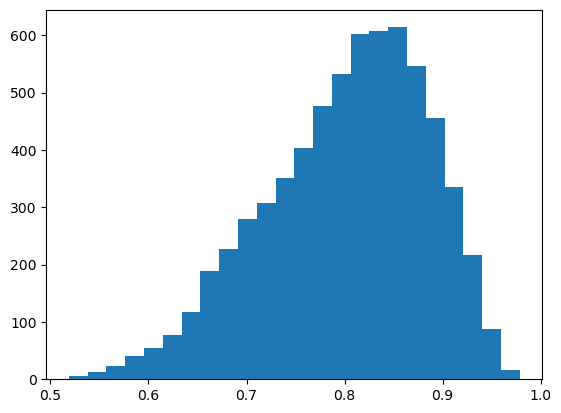

In [26]:
plt.hist(proper_int, bins=24)

(array([  1.,   3.,   7.,  20.,  60.,  81., 171., 177., 267., 295., 371.,
        434., 502., 520., 600., 628., 690., 667., 467., 339., 161.,  58.,
         17.,   8.]),
 array([0.48243308, 0.5026968 , 0.5229606 , 0.54322433, 0.5634881 ,
        0.58375186, 0.60401565, 0.6242794 , 0.6445432 , 0.6648069 ,
        0.6850707 , 0.7053344 , 0.7255982 , 0.74586195, 0.7661257 ,
        0.78638947, 0.8066532 , 0.826917  , 0.8471807 , 0.8674445 ,
        0.88770825, 0.90797204, 0.92823577, 0.94849956, 0.9687633 ],
       dtype=float32),
 <BarContainer object of 24 artists>)

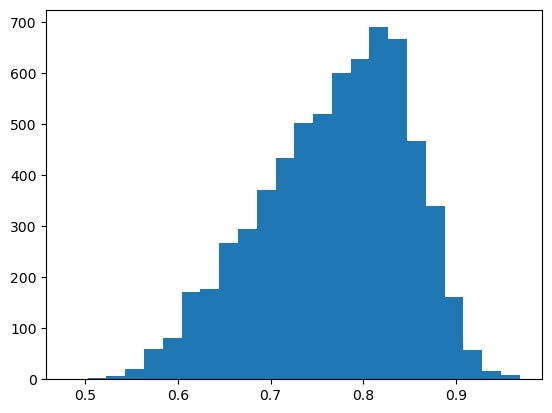

In [27]:
plt.hist(unfit_int, bins=24)